Importing Dependencies

In this project, I'll start with a standard regression model in PyTorch and the compare that to a more complex model in SciKit

In [42]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader , TensorDataset
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision import datasets
from torch.optim import Adam
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF


from sklearn.datasets import fetch_california_housing
import numpy as np
from sklearn.model_selection import train_test_split


Loading data and converting it to tensors

In [43]:
data_set = fetch_california_housing()
feature_labels = data_set.feature_names

print(feature_labels)

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


Plot where our data points are geographically

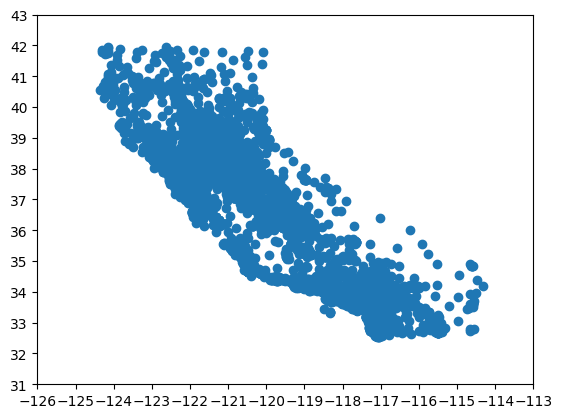

In [44]:
input_data = data_set.data
price = data_set.target

# columns 7 and 6 are the longitude and latitude reespectively

plt.scatter(input_data[:,7],input_data[:,6])
plt.yticks(np.arange(31, 44, step=1))
plt.xticks(np.arange(-126, -112, step=1))

plt.show()

That looks like California

I created this function to return important statistical values of the dataset

This will be useful for regularization and cleaning purposes

In [45]:
def find_stats(data) -> tuple[int,int]:

    feature_means = np.round(np.mean(data, axis=0),3)
    feature_stdev = np.std(data,axis=0)

    return feature_means , feature_stdev


More data visualizations

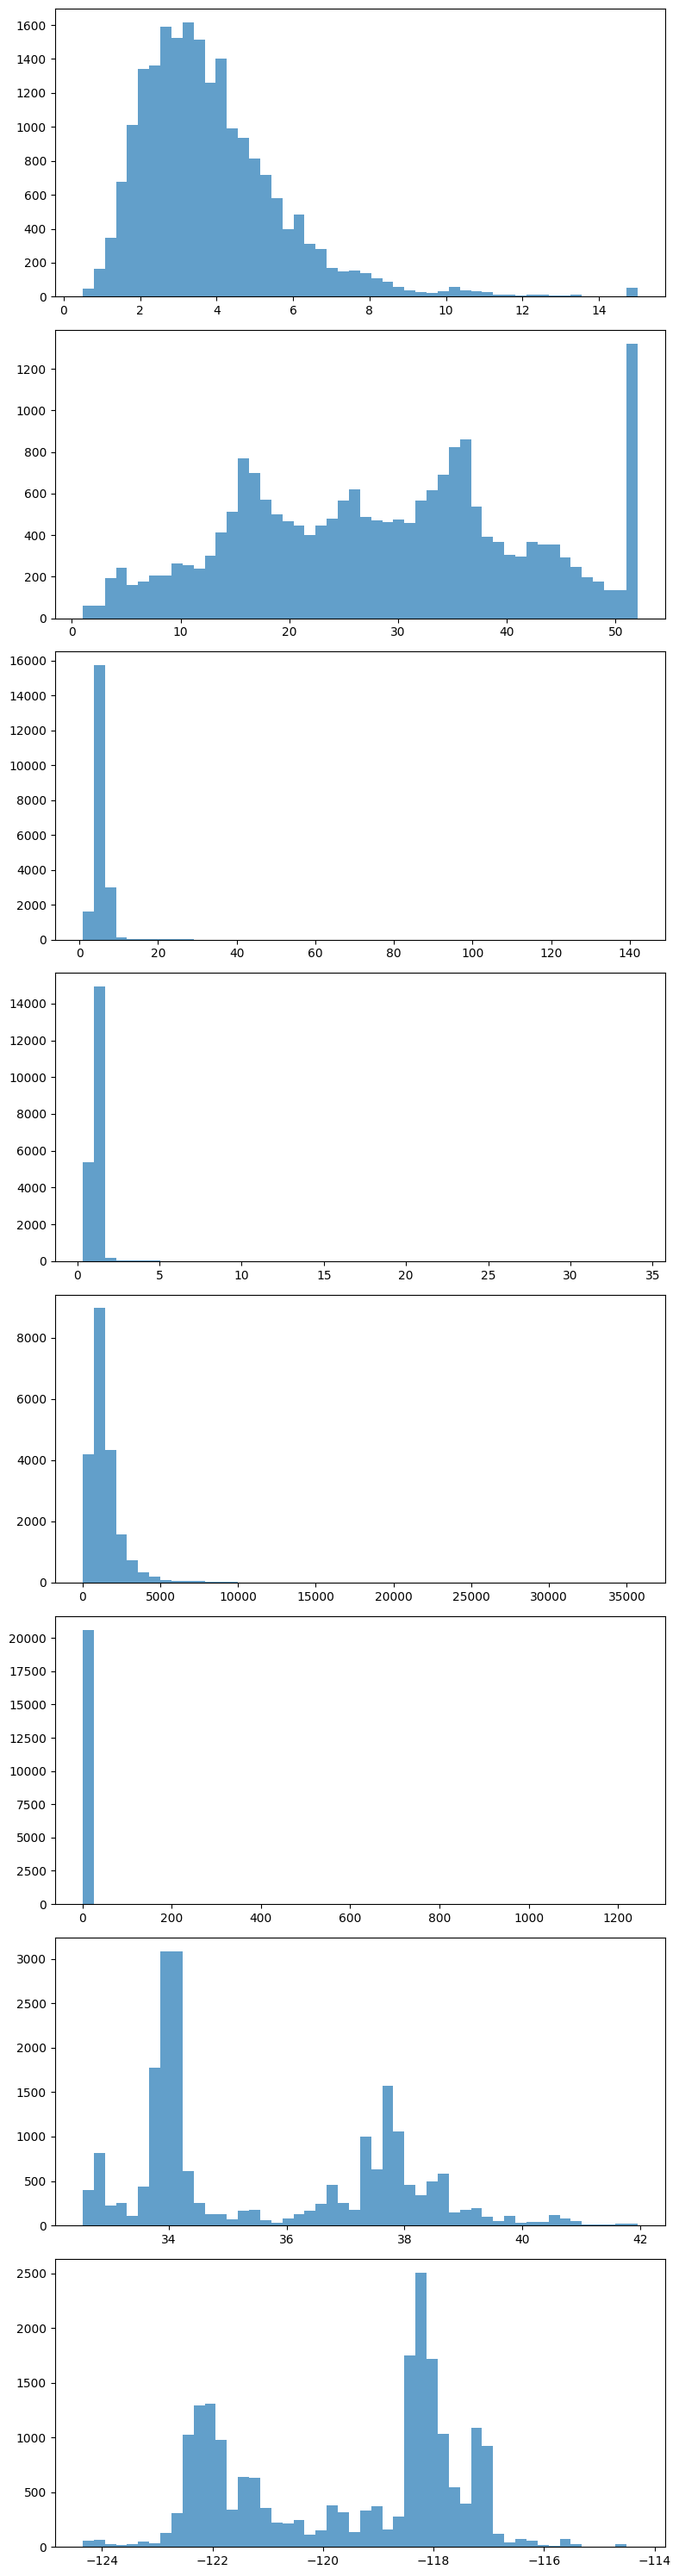

In [64]:

fig, axs = plt.subplots(input_data.shape[1], figsize=(8, 30))

for i in range(input_data.shape[1]):

    axs[i].hist(input_data[:, i], bins=50, alpha=0.7)


plt.tight_layout()
plt.show()

Data visualization (#2)

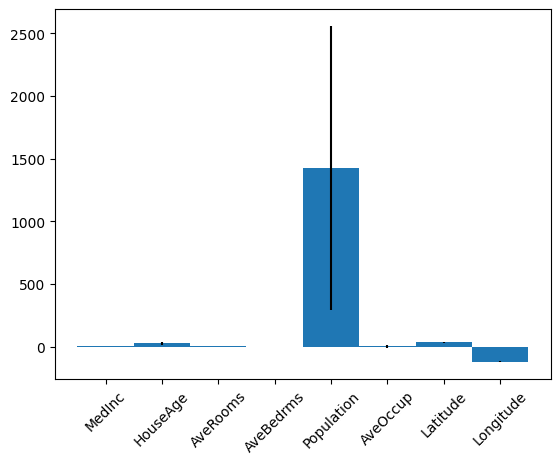

In [47]:
def bar_graph_data(data) -> None:   
    means , stdevs = find_stats(data)
    plt.bar(feature_labels, means, width=1, yerr=stdevs)
    plt.xticks(rotation=45) 

    plt.show

bar_graph_data(input_data)

With the feature values so disproportionate, it is difficult for our model to descend to the correct weights
Data normalization

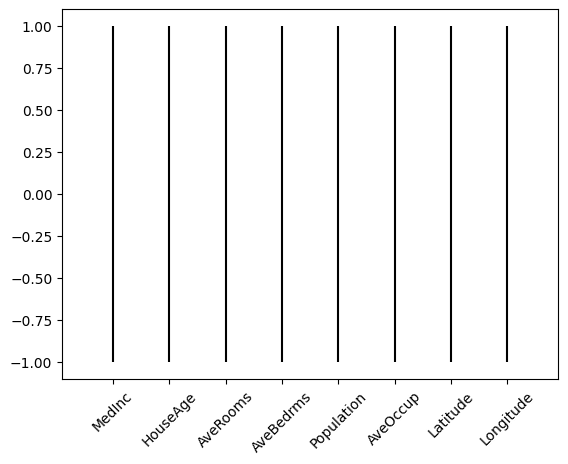

In [48]:
means , stdev = find_stats(input_data)

subtracted_data = input_data - means
# subtracting the mean from each feature value shifts the data so that the mean is 0

normalized_data = subtracted_data/stdev

# dividing by the standard deviation condenses or stretches the data so that each column has a StDev of 1
# this will allow all of our parameters to learn at the same rate

bar_graph_data(normalized_data)

# this graph looks a little silly because the blue bars (that represent the mean of each feature) are all 0, and the StDevs are all 1

Here's what our normalized data looks like graphed, the feature value (which now doesn't hold much of a real world significance, to us at least) is the x-axis, the value of the home is the y-axis

Data visualization (#3)

While our data has lost most of its easily interperetable real life application, it still maintains its relationship relative to the target values and other values of the same feature 

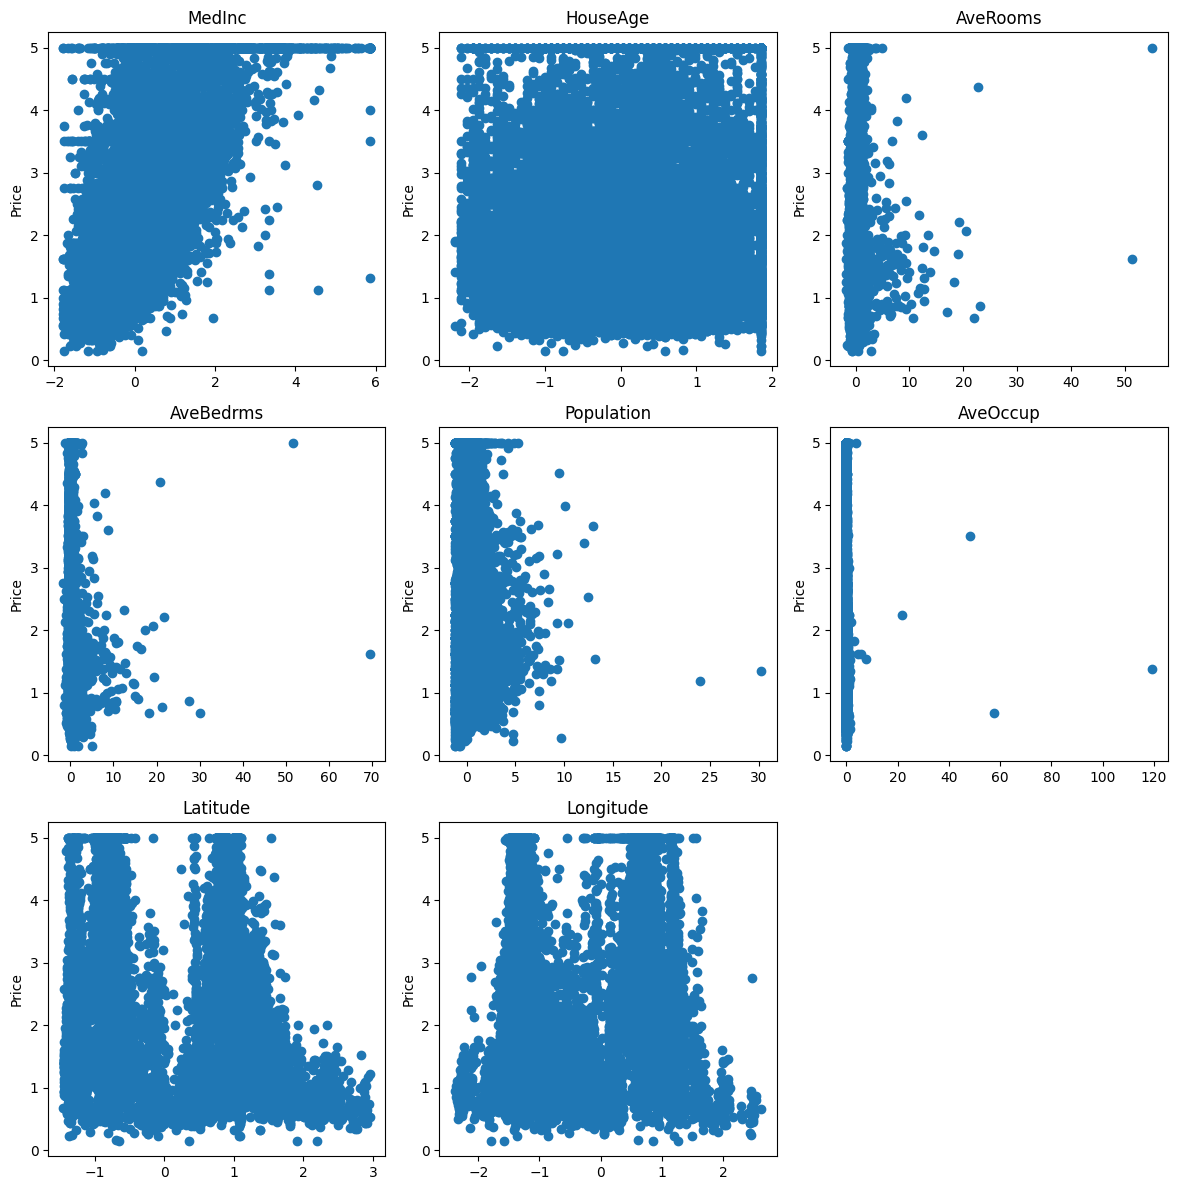

In [49]:
def display_data(data, price, feature_labels) -> None:
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))

    axes = axes.flatten()
    
    for i in range(9):
        if i >= len(feature_labels):
            fig.delaxes(axes[i])
            break
        axes[i].scatter(data[:, i], price)
        axes[i].set_title(feature_labels[i])

        axes[i].set_ylabel("Price")

    plt.tight_layout()
    plt.show()


display_data(normalized_data, price, feature_labels)

- Remove outliers 3+ stdevs from average

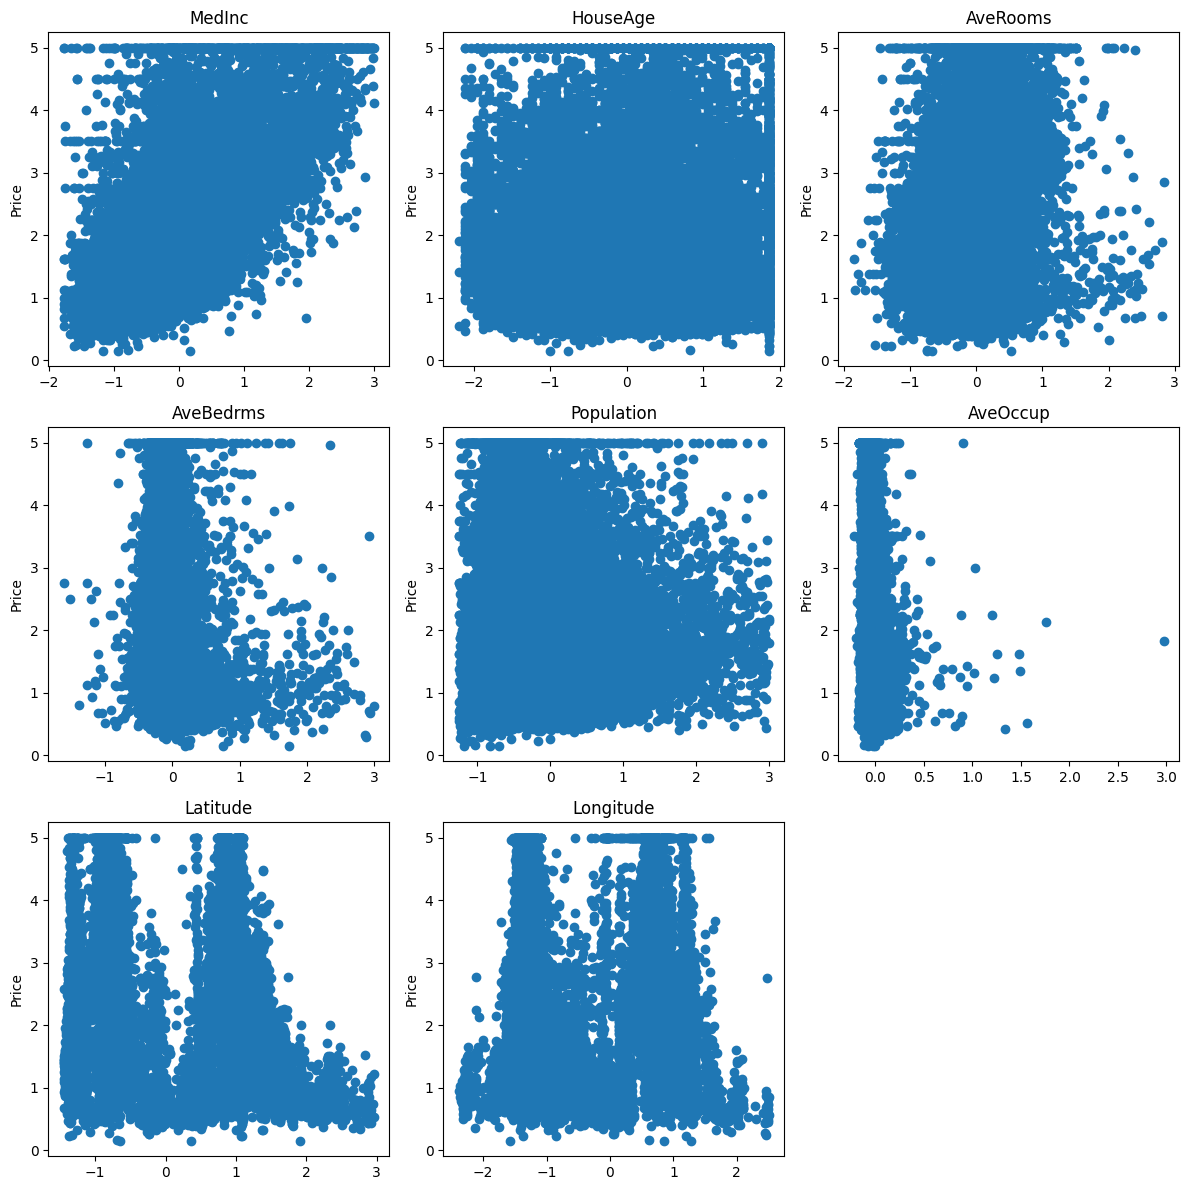

(19794, 8)

In [50]:
# eliminate outliers x stdevs from the mean
x = 3 
means , stdevs = find_stats(normalized_data)

# because our data is normalized now, any example with a value above 3 or below -3 will be removed

upper_bound = 3
lower_bound = -3

outliers = np.logical_or(normalized_data > upper_bound, normalized_data < lower_bound)
outliers_any = np.any(outliers, axis=1)

cleaned_data = normalized_data[~outliers_any]
cleaned_target = price[~outliers_any]




display_data(cleaned_data, cleaned_target, feature_labels)

cleaned_data.shape

I will use the cleaned data for training, uncleaned (but still normalized) data for testing.

You can't use cleaned data for testing because actually applications of the model will not be used on cleaned datasets. Only on real, uncleaned set.

I'll splice the set into roughly a 85% train : 15% test split. 

In [51]:
# Take a subset of our cleaned data out for training
# I don't want to test the model on cleaned data

X_train = cleaned_data[:17000]
y_train = cleaned_target[:17000].reshape(17000,1)

# Setting test arrays as [16000:] because we removed some examples (< 1000) and we don't want any overlap

X_test = normalized_data[18000:20000]
y_test = price[18000:20000].reshape(2000,1)



Convert data -> tensor object -> DataLoader object

Useful for batch descent and further regularization

In [52]:

X = torch.tensor(X_train, dtype=torch.float32)
Y = torch.tensor(y_train, dtype=torch.float32)
X1 = torch.tensor(X_test, dtype=torch.float32)
Y1 = torch.tensor(y_test, dtype=torch.float32)


train_dataset = TensorDataset(X,Y)
test_dataset = TensorDataset(X1,Y1)
train_set = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_set = DataLoader(test_dataset, batch_size=2000, shuffle=False)


Define NN architecture

I want to maintain as much complexity as possible, without overfitting

Four hidden linear layers, all with ReLu activation

Dropout of 0.1 applied to each layer, there are very few nodes in each layer, increasing dropout results in very poor performace

In [53]:
class Net(nn.Module):
    def __init__(self, input_features, h_1_features , h_2_features , h_3_features , h_4_features) -> None:
        super(Net, self).__init__()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)

        self.linear1 = nn.Linear(input_features, h_1_features)
        self.linear2 = nn.Linear(h_1_features, h_2_features)
        self.linear3 = nn.Linear(h_2_features, h_3_features)
        self.linear4 = nn.Linear(h_3_features, h_4_features)


        
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.dropout(x)
    
        x = self.linear3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear4(x)

        x = self.relu(x)
        x = self.dropout(x)
        return x

Initialize the model, optimizer, and loss function

I'm using MSE as the loss function because our objective is to predict an int value closest to y_true

Adam (adaptive moment estimation) as optimizer 

Benefits of Adam:

- Adapts a unique learning rate for each hyper-parameter. This further 'normalizes' our data, at least it normalizes the way in which the model interperets data
- Without hyper-parameter tuning (very resource intensive), Adam performs better than SGD because of its bias correction and resistence to gradient explosion
- Generally more robust than SGD, SGD is a little bit more sensitive and requires more resources to achieve comperable results

With experiementation, I found that a model with more nodes in each layer led to overfitting

With a dataset with very vague relationships, such as this one, it is import to balance architecture complexity and robustness of the model

In [54]:
model = Net(8, 3, 4 , 3,1)
loss = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.0001)
num_epochs = 50


A function that evaluates our model on the test set

In [55]:
import math
def test_model():
    model.eval()


    with torch.no_grad():
        for data, target in test_set:
            y_pred = model(data)
            cost = loss(y_pred, target)

    return math.sqrt(cost.item())

Construct the loop for gradient descent

Epoch [5/50], Training Loss: 4.1375975757837296, Test RMSE: 2.034254346513084
Epoch [10/50], Training Loss: 1.335504854619503, Test RMSE: 0.8806086011974674
Epoch [15/50], Training Loss: 1.20143698686186, Test RMSE: 0.799695278784308
Epoch [20/50], Training Loss: 1.1271578805455391, Test RMSE: 0.7810387898091383
Epoch [25/50], Training Loss: 1.1011111278700478, Test RMSE: 0.7845049002028159
Epoch [30/50], Training Loss: 1.1321426403040395, Test RMSE: 0.7860233206941438
Epoch [35/50], Training Loss: 1.0451675629725352, Test RMSE: 0.7792658214070524
Epoch [40/50], Training Loss: 1.051599060288247, Test RMSE: 0.7643212096906292
Epoch [45/50], Training Loss: 1.0466495603191501, Test RMSE: 0.7765901833095787
Epoch [50/50], Training Loss: 1.0435504400686306, Test RMSE: 0.7679444426592728


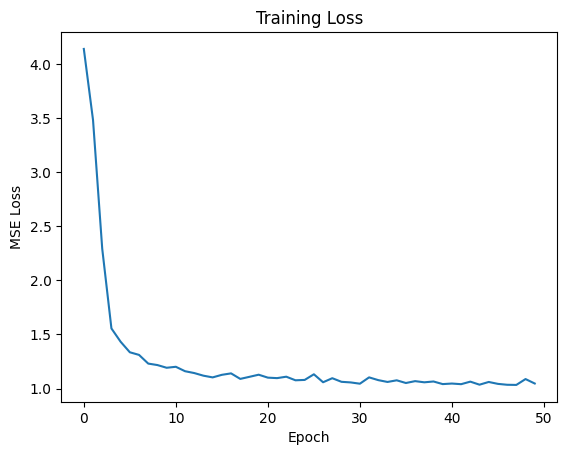

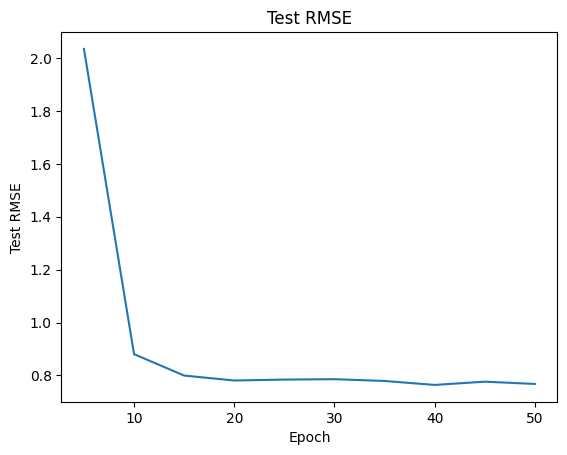

In [ ]:
loss_history = []
RMSE_history = []
for i in range(num_epochs):
    model.train()
    epoch_cost = 0
    for batch_idx, (data, target) in enumerate(train_set):

        y_pred = model(data)
        cost = loss(y_pred, target)
        
        
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_cost += cost.item()
    
    epoch_cost /= len(train_set)
    loss_history.append(epoch_cost)
    

    if i % 5 == 0:
        test_rmse = test_model()
        RMSE_history.append(test_rmse)
        print(f'Epoch [{i+5}/{num_epochs}], Training Loss: {epoch_cost}, Test RMSE: {test_rmse}')
    

plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.show()

plt.plot(range(5, num_epochs + 1, 5), RMSE_history)
plt.xlabel('Epoch')
plt.ylabel('Test RMSE')
plt.title('Test RMSE')
plt.show()

This model isn't too good. We are off by a pretty good margin (RMSE). If you look back at our data, you can see why

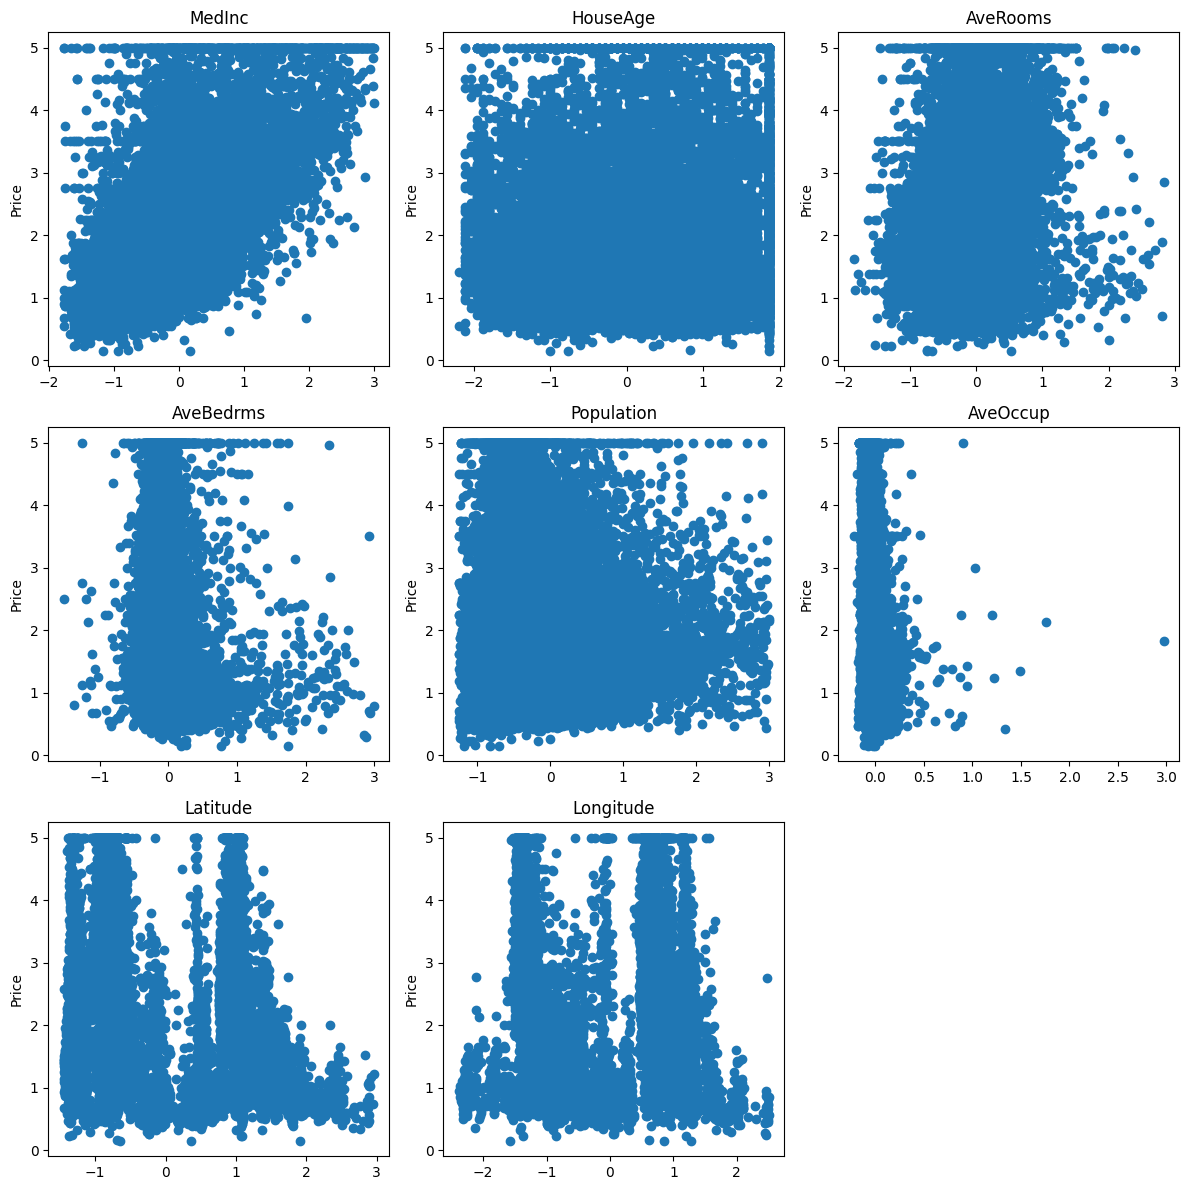

In [ ]:
display_data(X,Y, feature_labels)

If you try to draw a line of best fit in any of our features, you will either overfit the data or underfit it. In our case, because we used dropout, we underfit. Without dropout, the network performs very well on the train set (0.05 RMSE) but it begins to diverge on the test set. A linear model simply isn't capable of highly accurate predictions on this set.

Random forest regression will suit our data set better
- Better at finding hidden relationships in data
    - Our data is somewhat incomplete
    - While we could create new points: Proximity to city center, proximity to ocean, we can have the model more or less do it for us
- Random forest regression is a more holisitc approach, it accounts for the variables with respect to each other 

- Import some more dependencies from SciKit-learn
- Random forest regression isn't built into PyTorch unfortunately

In [57]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error

y_train = y_train.ravel()
y_test = y_test.ravel()

# set random state = 0 for parity
sk_model = RandomForestRegressor(random_state=0)

# train the model
sk_model.fit(X_train, y_train)

# test the model
y_pred = sk_model.predict(X_test)

# calculate error
mse = mean_squared_error(y_test, y_pred)

# return values
print(f'MSE: {mse} -- RMSE: {root_mean_squared_error(y_test, y_pred)}')


MSE: 0.3150286644457198 -- RMSE: 0.5612741437530503


With only the default hyper parameters of RandomForestRegressor, SK-learn out performed the linear PyTorch model by roughly 33%

With hyper parameter tuning, we can squeeze a couple more percent out of the model (hopefully)

In [26]:
space = {
    'max_depth': [5,10,15],
    'n_estimators': [50,100,150],
    'max_features': [5,10,15]
}

In [27]:
from sklearn.model_selection import GridSearchCV
GS = GridSearchCV(estimator=sk_model,
                  param_grid=space,
                  scoring=['r2', 'neg_mean_squared_error'],
                  refit='r2',
                  cv=5
                  )


In [28]:
GS.fit(X_train,y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END max_depth=5, max_features=5, n_estimators=50; neg_mean_squared_error: (test=-0.678) r2: (test=0.146) total time=   0.9s
[CV 2/5] END max_depth=5, max_features=5, n_estimators=50; neg_mean_squared_error: (test=-0.674) r2: (test=0.443) total time=   0.9s
[CV 3/5] END max_depth=5, max_features=5, n_estimators=50; neg_mean_squared_error: (test=-0.465) r2: (test=0.617) total time=   0.9s
[CV 4/5] END max_depth=5, max_features=5, n_estimators=50; neg_mean_squared_error: (test=-0.456) r2: (test=0.459) total time=   0.8s
[CV 5/5] END max_depth=5, max_features=5, n_estimators=50; neg_mean_squared_error: (test=-0.984) r2: (test=0.263) total time=   0.8s
[CV 1/5] END max_depth=5, max_features=5, n_estimators=100; neg_mean_squared_error: (test=-0.700) r2: (test=0.117) total time=   2.0s
[CV 2/5] END max_depth=5, max_features=5, n_estimators=100; neg_mean_squared_error: (test=-0.665) r2: (test=0.450) total time=   2.2s
[CV 3

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
             param_grid={'max_depth': [5, 10, 15], 'max_features': [5, 10, 15],
                         'n_estimators': [50, 100, 150]},
             refit='r2', scoring=['r2', 'neg_mean_squared_error'], verbose=4)

In [30]:
print(GS.best_estimator_)

RandomForestRegressor(max_depth=15, max_features=10, n_estimators=150,
                      random_state=0)


We see that the best values for max_depth and n_estimators were the extremes. This suggests that the optimal values for these parameters is greater than our currect maxes.

Retest model on new parameters

In [63]:
sk_model = RandomForestRegressor(random_state=0, max_features=10, n_estimators=150, max_depth=15)

sk_model.fit(X_train, y_train)


y_pred = sk_model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)

print(f'MSE: {mse} -- RMSE: {root_mean_squared_error(y_test, y_pred)}')

MSE: 0.31664389650872804 -- RMSE: 0.5627112016911766


It turns out that our hyper-parameter tuning didn't bring our test RMSE down (it actually increased slightly)

Constraining the model descreaed the overfitting problem but it didn't help our underfitting problem

The models are limitted by their achitecture, to achieve a more accurate result we would have to explore models with higher complexityb

Final accuracies (calculated by (RMSE + Y_mean)/Y_mean):

- PyTorch linear model ~25% off
- SciKit-learn RandomForestRegression mode ~18% off